# Setup enviorment

In [ ]:
%cd ..

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std_classification

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""
embeddings_dir = 'Embeddings/'
embeddings = 'Embeddings/ResNet50V2_224_1024.csv'
labels = '../Tabular_data/Label_CSV_All_Municipality.csv'
cases = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/ResNet50V2_224_1024.csv')['Municipality Code']))


""" Dataset Preprocessing:"""
train_percentage = 80
T=3
autoregressive = True
feature_range = (-1, 1)
fusion = 'joint'

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 3]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False


## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, cases=cases) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [4]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5         6    7  \
41001 201601 -1.0 -1.0 -0.983295 -1.000000 -1.000000 -1.0 -0.778869 -1.0   
      201602 -1.0 -1.0 -0.965792 -0.570709 -0.916188 -1.0 -1.000000 -1.0   
      201603 -1.0 -1.0 -0.965792 -0.570709 -0.916188 -1.0 -1.000000 -1.0   
      201604 -1.0 -1.0 -0.965792 -0.570709 -0.916188 -1.0 -1.000000 -1.0   
      201605 -1.0 -1.0 -0.965792 -0.570709 -0.916188 -1.0 -1.000000 -1.0   

                     8         9  ...      2040      2041  2042      2043  \
41001 201601 -0.958992 -1.000000  ... -0.728001 -1.000000  -1.0 -0.829446   
      201602 -1.000000 -0.902422  ... -0.900735 -0.809416  -1.0 -1.000000   
      201603 -1.000000 -0.902422  ... -0.900735 -0.809416  -1.0 -1.000000   
      201604 -1.000000 -0.902422  ... -0.900735 -0.809416  -1.0 -1.000000   
      201605 -1.000000 -0.902422  ... -0.900735 -0.809416  -1.0 -1.000000   

                2044  2045      2046      2047     cases  Labels  
41001 201601 -1.0000  -1.0 -0.290000 -0.887215 -0.849821     0.0  
      201602 -0.5034  -1.0 -0.918507 -1.000000 -0.878427    -1.0  
      201603 -0.5034  -1.0 -0.918507 -1.000000 -0.861740     1.0  
      201604 -0.5034  -1.0 -0.918507 -1.000000 -0.890346    -1.0  
      201605 -0.5034  -1.0 -0.918507 -1.000000 -0.904648    -1.0  

[5 rows x 2050 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0    1         2         3         4    5         6    7    8  \
5360 201601 -1.0 -1.0 -0.945901 -0.936821 -0.891960 -1.0 -0.951539 -1.0 -1.0   
     201602 -1.0 -1.0 -0.945901 -0.936821 -0.891960 -1.0 -0.951539 -1.0 -1.0   
     201603 -1.0 -1.0 -0.965792 -0.570709 -0.916188 -1.0 -1.000000 -1.0 -1.0   
     201604 -1.0 -1.0 -0.965792 -0.570709 -0.916188 -1.0 -1.000000 -1.0 -1.0   
     201605 -1.0 -1.0 -0.965792 -0.570709 -0.916188 -1.0 -1.000000 -1.0 -1.0   

                    9  ...      2040      2041     2042     2043    2044  \
5360 201601 -0.982862  ... -0.761882 -1.000000 -0.98379 -0.86338 -1.0000   
     201602 -0.982862  ... -0.761882 -1.000000 -0.98379 -0.86338 -1.0000   
     201603 -0.902422  ... -0.900735 -0.809416 -1.00000 -1.00000 -0.5034   
     201604 -0.902422  ... -0.900735 -0.809416 -1.00000 -1.00000 -0.5034   
     201605 -0.902422  ... -0.900735 -0.809416 -1.00000 -1.00000 -0.5034   

                 2045      2046  2047     cases  Labels  
5360 201601 -0.983399 -0.227419  -1.0 -0.971395     0.0  
     201602 -0.983399 -0.227419  -1.0 -0.952324     1.0  
     201603 -1.000000 -0.918507  -1.0 -0.954708     0.0  
     201604 -1.000000 -0.918507  -1.0 -0.957092     0.0  
     201605 -1.000000 -0.918507  -1.0 -0.930870     1.0  

[5 rows x 2050 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(153, 8200)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [10]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1224, 6150)
The shape of the labels is (1224, 1)
Test:
The shape of the features is (306, 6150)
The shape of the labels is (306, 1)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1224, 6150)
The test shape is (306, 6150)
-----------------------
The Final shapes are:
The train shape is (1224, 3, 2050)
The test shape is (306, 3, 2050)


In [12]:
### Imbalanced data
n_zeros = (train_y == -1).sum()
n_ones = (train_y == 0).sum()
n_twos = (train_y == 1).sum()
n_total = n_zeros + n_ones + n_twos

weights = {0: n_total/n_zeros, 1: n_total/n_ones, 2: n_total/n_twos}
weights = {0: 1, 1: 1, 2: 7}
print(f'Decrease: {n_zeros}, Stable: {n_ones}, Increase: {n_twos}, Total: {n_total}')
weights

Decrease: 187, Stable: 846, Increase: 191, Total: 1224


{0: 1, 1: 1, 2: 7}

# 2. Model

In [13]:
x_ar = train_X[:, :, -3:]
x_ar_test = test_X[:, :, -3:]

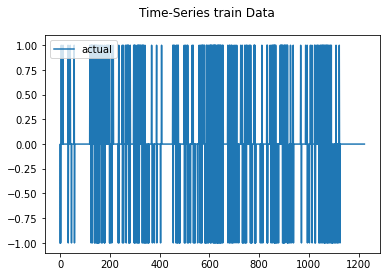

2023-03-02 17:40:55.550919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-02 17:40:55.550969: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-02 17:40:55.550994: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-02 17:40:55.551251: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 17:41:02.518792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         [(None, 3, 2050)]    0                                            
__________________________________________________________________________________________________
lstm_2_input (InputLayer)       [(None, 3, 3)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 3)            15365213    lstm_input[0][0]                 
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3)            7177213     lstm_2_input[0][0]               
__________

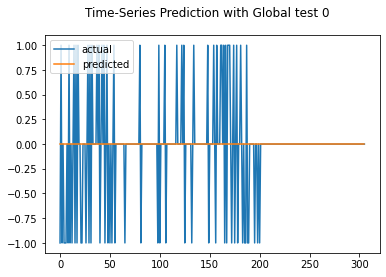

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_4_input (InputLayer)       [(None, 3, 2050)]    0                                            
__________________________________________________________________________________________________
lstm_6_input (InputLayer)       [(None, 3, 3)]       0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 3)            15365213    lstm_4_input[0][0]               
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 3)            7177213     lstm_6_input[0][0]               
____________________________________________________________________________________________

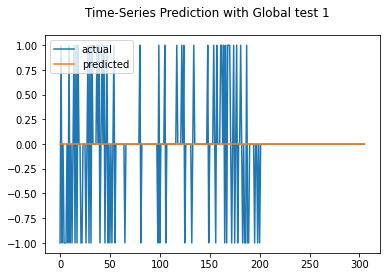

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_8_input (InputLayer)       [(None, 3, 2050)]    0                                            
__________________________________________________________________________________________________
lstm_10_input (InputLayer)      [(None, 3, 3)]       0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 3)            15365213    lstm_8_input[0][0]               
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 3)            7177213     lstm_10_input[0][0]              
________

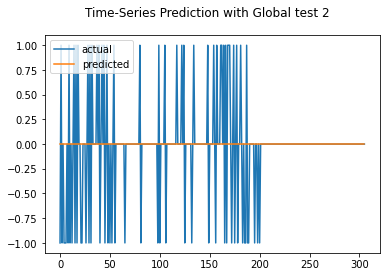

auc : average=0.853, std=0.036
acc : average=0.745, std=0.000
f1_score : average=0.285, std=0.403


([0.8527854283650717, 0.03583635870533163],
 [0.7450980544090271, 0.0],
 [0.2848041, 0.40277404])

In [14]:
# Use the Function:
sequence=train_X.shape[1]
features=train_X.shape[2]

calculate_mean_std_classification(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=3, plot_samples=True, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test)


### 3. Mode With Weights

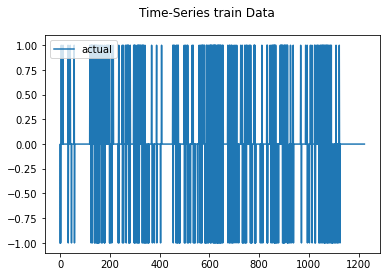

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_12_input (InputLayer)      [(None, 3, 2050)]    0                                            
__________________________________________________________________________________________________
lstm_14_input (InputLayer)      [(None, 3, 3)]       0                                            
_________________________________________

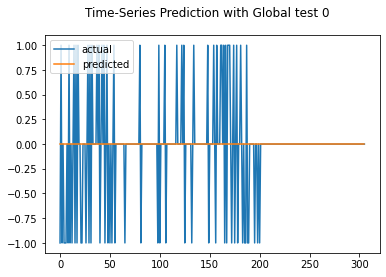

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_16_input (InputLayer)      [(None, 3, 2050)]    0                                            
_______________________________________________________________________________________________

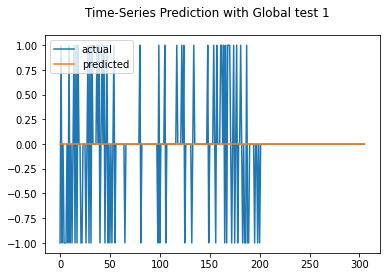

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_20_input (InputLayer)      [(None, 3, 2050)]    0                                            
__________________________________________________________________________________________________
lstm_22_input (InputLayer)      [(None, 3, 3)]       0                                            
_________________

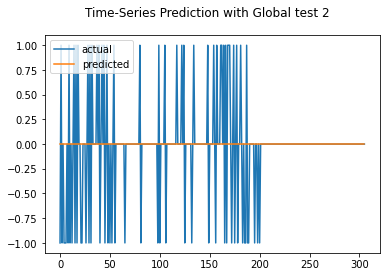

auc : average=0.842, std=0.022
acc : average=0.745, std=0.000
f1_score : average=0.285, std=0.403


In [15]:
sequence=train_X.shape[1]
features=train_X.shape[2]

weights = calculate_mean_std_classification(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=3, plot_samples=True, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test, weights=weights)
